In [4]:
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import balanced_accuracy_score, precision_score, roc_auc_score
from fairlearn.metrics import MetricFrame, selection_rate, demographic_parity_difference, equalized_odds_difference
from fairlearn.metrics import demographic_parity_ratio, equalized_odds_ratio
import seaborn as sns
from fairlearn.preprocessing import CorrelationRemover

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler

In [5]:
#reading file
file_path = "default_of_credit_card_clients.xls"

# Read Excel file into a DataFrame
df = pd.read_excel(file_path)

print(df)


X=df.drop(columns=['Y'])
X=X.drop(columns=['Unnamed: 0'])

X=X.drop(index=0)

y=df['Y']
y=y.drop(index=0)

y=pd.to_numeric(y)
y.head()
X = X[X['X3'] != 0]
X['X3'] = X['X3'].replace({5: 4, 6: 4})
X = X[X['X4'] != 0]
X['X4'] = X['X4'].replace({4:3,5: 3, 6: 3})
y = y[X.index]  # Update y to match the filtered rows in X
for column in X:
    X[column] = pd.to_numeric(X[column])
    X[column].head()


#minmax scaler or standard scaler

#split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

y.head()

      Unnamed: 0         X1   X2         X3        X4   X5     X6     X7  \
0             ID  LIMIT_BAL  SEX  EDUCATION  MARRIAGE  AGE  PAY_0  PAY_2   
1              1      20000    2          2         1   24      2      2   
2              2     120000    2          2         2   26     -1      2   
3              3      90000    2          2         2   34      0      0   
4              4      50000    2          2         1   37      0      0   
...          ...        ...  ...        ...       ...  ...    ...    ...   
29996      29996     220000    1          3         1   39      0      0   
29997      29997     150000    1          3         2   43     -1     -1   
29998      29998      30000    1          2         2   37      4      3   
29999      29999      80000    1          3         1   41      1     -1   
30000      30000      50000    1          2         1   46      0      0   

          X8     X9  ...        X15        X16        X17       X18       X19  \
0     

1    1
2    1
3    0
4    0
5    0
Name: Y, dtype: int64

weighting on X2

In [6]:
sensitive_train= X_train["X2"]
sensitive_test= X_test["X2"]

# Calculate selection rate for each sensitive group
selection_rate_male = y_train[sensitive_train == 1].mean()
selection_rate_female = y_train[sensitive_train == 2].mean()

# Calculate inverse of selection rate
inverse_rate_male = 1 / selection_rate_male if selection_rate_male> 0 else 1
inverse_rate_female = 1 / selection_rate_female if selection_rate_female > 0 else 1

# Normalize the weights to make them sum to the number of samples (keeps the effective size of the dataset unchanged)
normalization_factor = (len(y_train) / (inverse_rate_male * (sensitive_train == 1).sum() + inverse_rate_female * (sensitive_train == 2).sum()))

# Create sample weights based on the sensitive feature
sample_weights = np.ones(len(y_train))
sample_weights[sensitive_train == 1] = inverse_rate_male * normalization_factor
sample_weights[sensitive_train == 2] = inverse_rate_female * normalization_factor

clf = RandomForestClassifier(random_state=42)
clf.fit(X_train, y_train, sample_weight=sample_weights)
y_pred = clf.predict(X_test)
y_pred_prob = clf.predict_proba(X_test)[:,1]

In [7]:
accuracy = balanced_accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy}")

# Measure AUC
auc = roc_auc_score(y_test, y_pred_prob)
print(f"AUC: {auc}")

Accuracy: 0.6567249693555116
AUC: 0.7610915259499791


array([[<AxesSubplot:title={'center':'accuracy'}, xlabel='X2'>,
        <AxesSubplot:title={'center':'precision'}, xlabel='X2'>,
        <AxesSubplot:title={'center':'false positive rate'}, xlabel='X2'>],
       [<AxesSubplot:title={'center':'false negative rate'}, xlabel='X2'>,
        <AxesSubplot:title={'center':'selection rate'}, xlabel='X2'>,
        <AxesSubplot:xlabel='X2'>],
       [<AxesSubplot:xlabel='X2'>, <AxesSubplot:xlabel='X2'>,
        <AxesSubplot:xlabel='X2'>]], dtype=object)

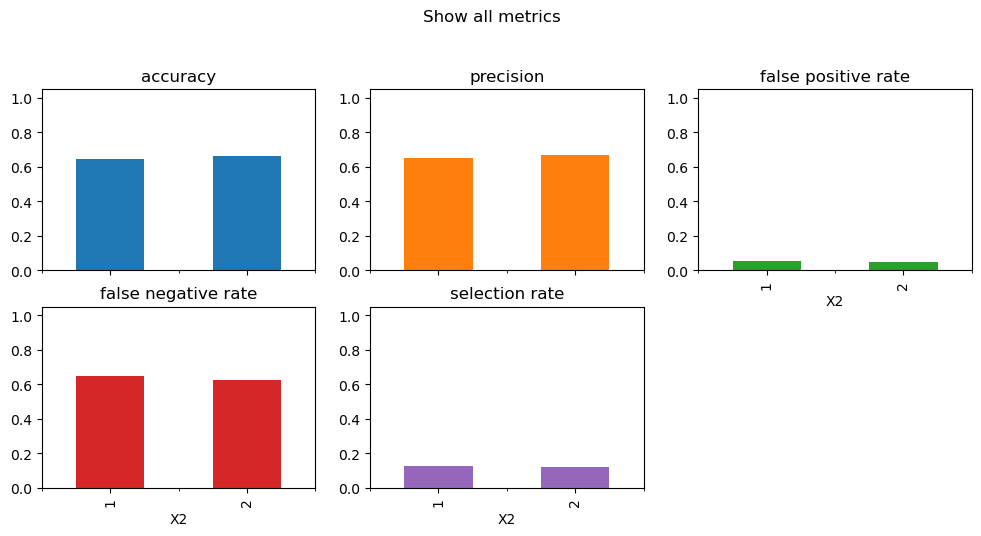

In [8]:
from fairlearn.metrics import (
    MetricFrame,
    count,
    false_negative_rate,
    false_positive_rate,
    selection_rate,
)
# Analyze metrics using MetricFrame
metrics = {
    "accuracy": balanced_accuracy_score,
    "precision": precision_score,
    "false positive rate": false_positive_rate,
    "false negative rate": false_negative_rate,
    "selection rate": selection_rate,
}
metric_frame = MetricFrame(
    metrics=metrics, y_true=y_test, y_pred=y_pred, sensitive_features=sensitive_test
)
metric_frame.by_group.plot.bar(
    subplots=True,
    layout=[3, 3],
    legend=False,
    figsize=[12, 8],
    ylim=[0,1.05],
    title="Show all metrics",
)

In [9]:
# Statistical Parity
stat_parity_diff = demographic_parity_difference(y_test, y_pred, sensitive_features=sensitive_test)
print(f"Statistical Parity Difference: {stat_parity_diff}")

stat_parity_rto = demographic_parity_ratio(y_test, y_pred, sensitive_features=sensitive_test)
print(f"Statistical Parity ratio: {stat_parity_rto}")

# Equalized Odds
equal_odds_diff = equalized_odds_difference(y_test, y_pred, sensitive_features=sensitive_test)
print(f"Equalized Odds Difference: {equal_odds_diff}")

equal_odds_rto = equalized_odds_ratio(y_test, y_pred, sensitive_features=sensitive_test)
print(f"Equalized Odds Ratio: {equal_odds_rto}")

Statistical Parity Difference: 0.007498779913683404
Statistical Parity ratio: 0.940856798953208
Equalized Odds Difference: 0.02724396994859629
Equalized Odds Ratio: 0.8687067847882454


weighting on X3

In [10]:
sensitive_train= X_train["X3"]
sensitive_test= X_test["X3"]

# Calculate selection rate for each sensitive group
selection_rate_ed_graduate = y_train[sensitive_train == 1].mean()
selection_rate_ed_uni = y_train[sensitive_train == 2].mean()
selection_rate_ed_high = y_train[sensitive_train == 3].mean()
selection_rate_ed_other = y_train[sensitive_train == 4].mean()

# Calculate inverse of selection rate
inverse_rate_ed_graduate = 1 / selection_rate_ed_graduate if selection_rate_ed_graduate> 0 else 1
inverse_rate_ed_uni = 1 / selection_rate_ed_uni if selection_rate_ed_uni > 0 else 1
inverse_rate_ed_high = 1 / selection_rate_ed_high if selection_rate_ed_high > 0 else 1
inverse_rate_ed_other = 1 / selection_rate_ed_other if selection_rate_ed_other > 0 else 1

# Normalize the weights to make them sum to the number of samples (keeps the effective size of the dataset unchanged)
normalization_factor = (len(y_train) / (inverse_rate_ed_graduate * (sensitive_train == 1).sum() + inverse_rate_ed_uni * (sensitive_train == 2).sum() + inverse_rate_ed_high * (sensitive_train == 3).sum() + inverse_rate_ed_other * (sensitive_train == 4).sum()))

# Create sample weights based on the sensitive feature
sample_weights = np.ones(len(y_train))
sample_weights[sensitive_train == 1] = inverse_rate_ed_graduate * normalization_factor
sample_weights[sensitive_train == 2] = inverse_rate_ed_uni * normalization_factor
sample_weights[sensitive_train == 3] = inverse_rate_ed_high * normalization_factor
sample_weights[sensitive_train == 4] = inverse_rate_ed_other * normalization_factor

clf = RandomForestClassifier(random_state=42)
clf.fit(X_train, y_train, sample_weight=sample_weights)
y_pred = clf.predict(X_test)
y_pred_prob = clf.predict_proba(X_test)[:,1]

In [11]:
accuracy = balanced_accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy}")

# Measure AUC
auc = roc_auc_score(y_test, y_pred_prob)
print(f"AUC: {auc}")

Accuracy: 0.6554873039642163
AUC: 0.7571210837314152


array([[<AxesSubplot:title={'center':'accuracy'}, xlabel='X3'>,
        <AxesSubplot:title={'center':'precision'}, xlabel='X3'>,
        <AxesSubplot:title={'center':'false positive rate'}, xlabel='X3'>],
       [<AxesSubplot:title={'center':'false negative rate'}, xlabel='X3'>,
        <AxesSubplot:title={'center':'selection rate'}, xlabel='X3'>,
        <AxesSubplot:xlabel='X3'>],
       [<AxesSubplot:xlabel='X3'>, <AxesSubplot:xlabel='X3'>,
        <AxesSubplot:xlabel='X3'>]], dtype=object)

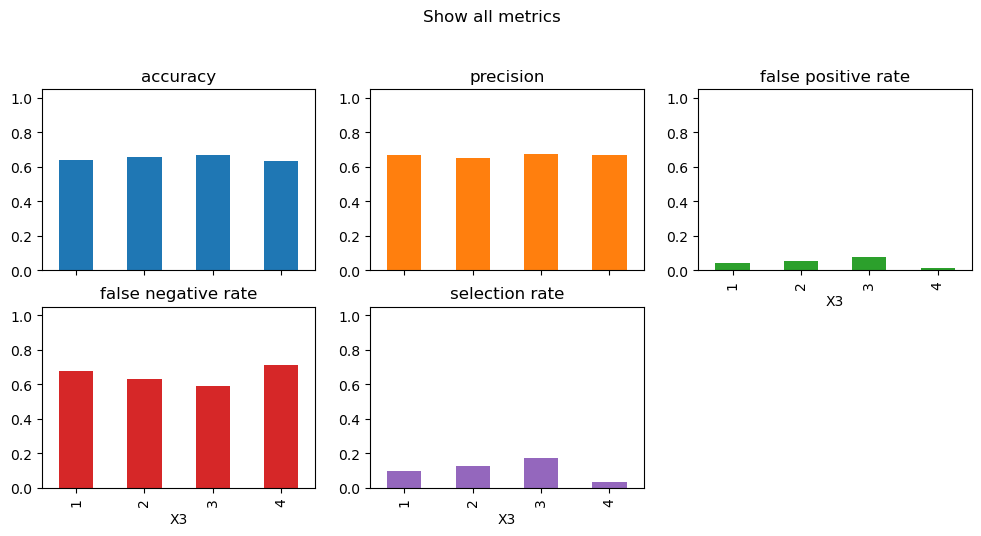

In [12]:
from fairlearn.metrics import (
    MetricFrame,
    count,
    false_negative_rate,
    false_positive_rate,
    selection_rate,
)
# Analyze metrics using MetricFrame
metrics = {
    "accuracy": balanced_accuracy_score,
    "precision": precision_score,
    "false positive rate": false_positive_rate,
    "false negative rate": false_negative_rate,
    "selection rate": selection_rate,
}
metric_frame = MetricFrame(
    metrics=metrics, y_true=y_test, y_pred=y_pred, sensitive_features=sensitive_test
)
metric_frame.by_group.plot.bar(
    subplots=True,
    layout=[3, 3],
    legend=False,
    figsize=[12, 8],
    ylim=[0,1.05],
    title="Show all metrics",
)

In [13]:
# Statistical Parity
stat_parity_diff = demographic_parity_difference(y_test, y_pred, sensitive_features=sensitive_test)
print(f"Statistical Parity Difference: {stat_parity_diff}")

stat_parity_rto = demographic_parity_ratio(y_test, y_pred, sensitive_features=sensitive_test)
print(f"Statistical Parity ratio: {stat_parity_rto}")

# Equalized Odds
equal_odds_diff = equalized_odds_difference(y_test, y_pred, sensitive_features=sensitive_test)
print(f"Equalized Odds Difference: {equal_odds_diff}")

equal_odds_rto = equalized_odds_ratio(y_test, y_pred, sensitive_features=sensitive_test)
print(f"Equalized Odds Ratio: {equal_odds_rto}")

Statistical Parity Difference: 0.13557191363624582
Statistical Parity ratio: 0.21251129177958444
Equalized Odds Difference: 0.12560646900269545
Equalized Odds Ratio: 0.17006289308176104


weighting on X4

In [14]:
sensitive_train= X_train["X4"]
sensitive_test= X_test["X4"]

# Calculate selection rate for each sensitive group
selection_rate_married = y_train[sensitive_train == 1].mean()
selection_rate_single = y_train[sensitive_train == 2].mean()
selection_rate_other = y_train[sensitive_train == 3].mean()


# Calculate inverse of selection rate
inverse_rate_married = 1 / selection_rate_married if selection_rate_married> 0 else 1
inverse_rate_single = 1 / selection_rate_single if selection_rate_single > 0 else 1
inverse_rate_other = 1 / selection_rate_other if selection_rate_other > 0 else 1

# Normalize the weights to make them sum to the number of samples (keeps the effective size of the dataset unchanged)
normalization_factor = (len(y_train) / (inverse_rate_married * (sensitive_train == 1).sum() + inverse_rate_single * (sensitive_train == 2).sum() + inverse_rate_other * (sensitive_train == 3).sum()))

# Create sample weights based on the sensitive feature
sample_weights = np.ones(len(y_train))
sample_weights[sensitive_train == 1] = inverse_rate_married * normalization_factor
sample_weights[sensitive_train == 2] = inverse_rate_single * normalization_factor
sample_weights[sensitive_train == 3] = inverse_rate_other * normalization_factor

clf = RandomForestClassifier(random_state=42)
clf.fit(X_train, y_train, sample_weight=sample_weights)
y_pred = clf.predict(X_test)
y_pred_prob = clf.predict_proba(X_test)[:,1]

In [15]:
accuracy = balanced_accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy}")

# Measure AUC
auc = roc_auc_score(y_test, y_pred_prob)
print(f"AUC: {auc}")

Accuracy: 0.6502696553263193
AUC: 0.7584094459411819


array([[<AxesSubplot:title={'center':'accuracy'}, xlabel='X4'>,
        <AxesSubplot:title={'center':'precision'}, xlabel='X4'>,
        <AxesSubplot:title={'center':'false positive rate'}, xlabel='X4'>],
       [<AxesSubplot:title={'center':'false negative rate'}, xlabel='X4'>,
        <AxesSubplot:title={'center':'selection rate'}, xlabel='X4'>,
        <AxesSubplot:xlabel='X4'>],
       [<AxesSubplot:xlabel='X4'>, <AxesSubplot:xlabel='X4'>,
        <AxesSubplot:xlabel='X4'>]], dtype=object)

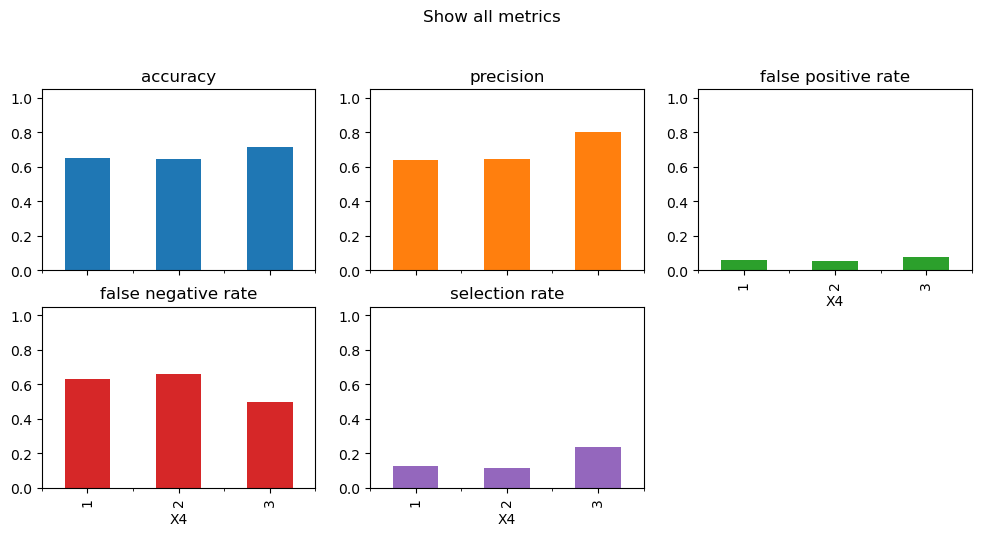

In [16]:
from fairlearn.metrics import (
    MetricFrame,
    count,
    false_negative_rate,
    false_positive_rate,
    selection_rate,
)
# Analyze metrics using MetricFrame
metrics = {
    "accuracy": balanced_accuracy_score,
    "precision": precision_score,
    "false positive rate": false_positive_rate,
    "false negative rate": false_negative_rate,
    "selection rate": selection_rate,
}
metric_frame = MetricFrame(
    metrics=metrics, y_true=y_test, y_pred=y_pred, sensitive_features=sensitive_test
)
metric_frame.by_group.plot.bar(
    subplots=True,
    layout=[3, 3],
    legend=False,
    figsize=[12, 8],
    ylim=[0,1.05],
    title="Show all metrics",
)

In [17]:
# Statistical Parity
stat_parity_diff = demographic_parity_difference(y_test, y_pred, sensitive_features=sensitive_test)
print(f"Statistical Parity Difference: {stat_parity_diff}")

stat_parity_rto = demographic_parity_ratio(y_test, y_pred, sensitive_features=sensitive_test)
print(f"Statistical Parity ratio: {stat_parity_rto}")

# Equalized Odds
equal_odds_diff = equalized_odds_difference(y_test, y_pred, sensitive_features=sensitive_test)
print(f"Equalized Odds Difference: {equal_odds_diff}")

equal_odds_rto = equalized_odds_ratio(y_test, y_pred, sensitive_features=sensitive_test)
print(f"Equalized Odds Ratio: {equal_odds_rto}")

Statistical Parity Difference: 0.1185789018250472
Statistical Parity ratio: 0.49406335221313197
Equalized Odds Difference: 0.15853658536585363
Equalized Odds Ratio: 0.6829268292682927


### 4.3

correlation remover on X3

In [20]:
#Sensitive data X3, X4
#columns=['X5','X6','X7','X8','X9','X10','X11','X12','X13','X14','X15','X16','X17','X18','X19','X20','X21','X22','X23']
cr = CorrelationRemover(sensitive_feature_ids=["X3"], alpha=0.5)
X_train_cr = cr.fit_transform(X_train)
X_train_cr = pd.DataFrame(X_train_cr)
print(X_train_cr.columns)
X_test_cr = cr.transform(X_test)
X_test_cr = pd.DataFrame(X_test_cr)

#sns.heatmap(X_train_cr.corr(), annot=True)

RangeIndex(start=0, stop=22, step=1)


In [21]:
clf = RandomForestClassifier(random_state=42)
clf.fit(X_train_cr, y_train)
y_pred = clf.predict(X_test_cr)
y_pred_prob = clf.predict_proba(X_test_cr)[:,1]

# Measure accuracy
accuracy = balanced_accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy}")

# Measure AUC
auc = roc_auc_score(y_test, y_pred_prob)
print(f"AUC: {auc}")

Accuracy: 0.654037552839507
AUC: 0.7572125320594713


array([[<AxesSubplot:title={'center':'accuracy'}, xlabel='X3'>,
        <AxesSubplot:title={'center':'precision'}, xlabel='X3'>,
        <AxesSubplot:title={'center':'false positive rate'}, xlabel='X3'>],
       [<AxesSubplot:title={'center':'false negative rate'}, xlabel='X3'>,
        <AxesSubplot:title={'center':'selection rate'}, xlabel='X3'>,
        <AxesSubplot:xlabel='X3'>],
       [<AxesSubplot:xlabel='X3'>, <AxesSubplot:xlabel='X3'>,
        <AxesSubplot:xlabel='X3'>]], dtype=object)

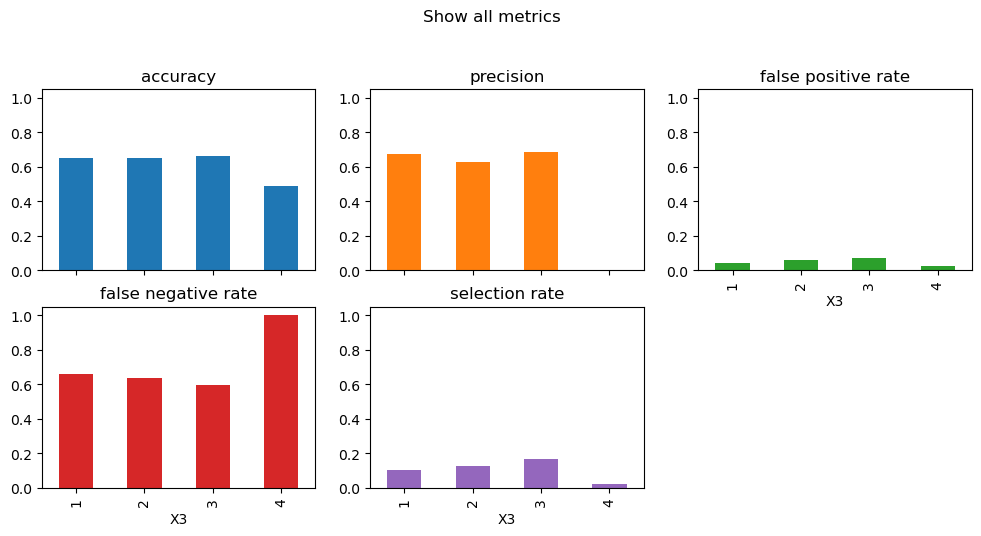

In [24]:
sensitive_test=X_test["X3"]
from fairlearn.metrics import (
    MetricFrame,
    count,
    false_negative_rate,
    false_positive_rate,
    selection_rate,
)
# Analyze metrics using MetricFrame
metrics = {
    "accuracy": balanced_accuracy_score,
    "precision": precision_score,
    "false positive rate": false_positive_rate,
    "false negative rate": false_negative_rate,
    "selection rate": selection_rate,
}
metric_frame = MetricFrame(
    metrics=metrics, y_true=y_test, y_pred=y_pred, sensitive_features=sensitive_test
)
metric_frame.by_group.plot.bar(
    subplots=True,
    layout=[3, 3],
    legend=False,
    figsize=[12, 8],
    ylim=[0,1.05],
    title="Show all metrics",
)

In [25]:

# Statistical Parity
stat_parity_diff = demographic_parity_difference(y_test, y_pred, sensitive_features=sensitive_test)
print(f"Statistical Parity Difference: {stat_parity_diff}")

stat_parity_rto = demographic_parity_ratio(y_test, y_pred, sensitive_features=sensitive_test)
print(f"Statistical Parity ratio: {stat_parity_rto}")

# Equalized Odds
equal_odds_diff = equalized_odds_difference(y_test, y_pred, sensitive_features=sensitive_test)
print(f"Equalized Odds Difference: {equal_odds_diff}")

equal_odds_rto = equalized_odds_ratio(y_test, y_pred, sensitive_features=sensitive_test)
print(f"Equalized Odds Ratio: {equal_odds_rto}")

Statistical Parity Difference: 0.1413908400508022
Statistical Parity ratio: 0.14712320200125079
Equalized Odds Difference: 0.4037735849056604
Equalized Odds Ratio: 0.0


correlation remover on X4

In [26]:
cr = CorrelationRemover(sensitive_feature_ids=["X4"], alpha=0.5)
X_train_cr = cr.fit_transform(X_train)
X_train_cr = pd.DataFrame(X_train_cr)
print(X_train_cr.columns)
X_test_cr = cr.transform(X_test)
X_test_cr = pd.DataFrame(X_test_cr)

clf = RandomForestClassifier(random_state=42)
clf.fit(X_train_cr, y_train)
y_pred = clf.predict(X_test_cr)
y_pred_prob = clf.predict_proba(X_test_cr)[:,1]

# Measure accuracy
accuracy = balanced_accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy}")

# Measure AUC
auc = roc_auc_score(y_test, y_pred_prob)
print(f"AUC: {auc}")

RangeIndex(start=0, stop=22, step=1)
Accuracy: 0.6550007115342944
AUC: 0.7629929396392522


array([[<AxesSubplot:title={'center':'accuracy'}, xlabel='X4'>,
        <AxesSubplot:title={'center':'precision'}, xlabel='X4'>,
        <AxesSubplot:title={'center':'false positive rate'}, xlabel='X4'>],
       [<AxesSubplot:title={'center':'false negative rate'}, xlabel='X4'>,
        <AxesSubplot:title={'center':'selection rate'}, xlabel='X4'>,
        <AxesSubplot:xlabel='X4'>],
       [<AxesSubplot:xlabel='X4'>, <AxesSubplot:xlabel='X4'>,
        <AxesSubplot:xlabel='X4'>]], dtype=object)

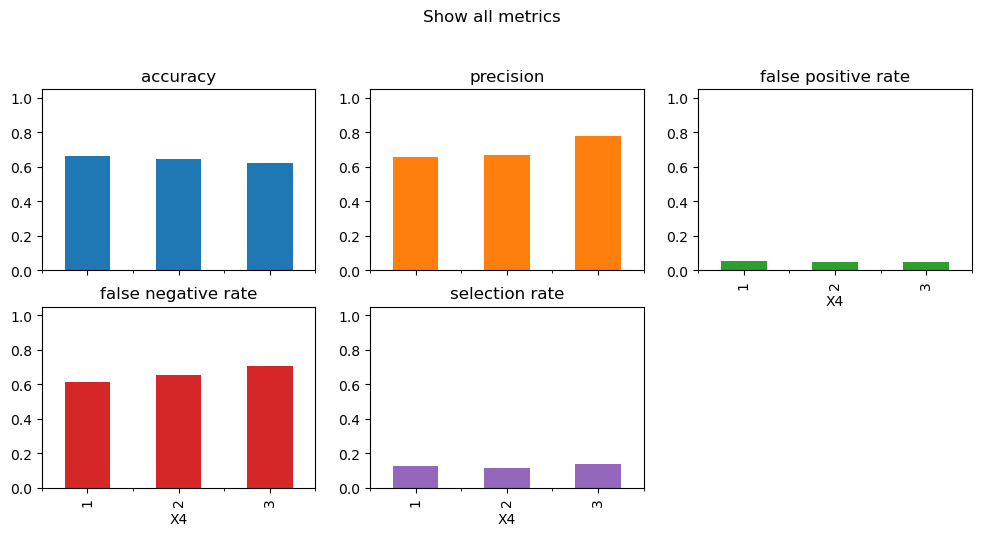

In [27]:
sensitive_test=X_test["X4"]
from fairlearn.metrics import (
    MetricFrame,
    count,
    false_negative_rate,
    false_positive_rate,
    selection_rate,
)
# Analyze metrics using MetricFrame
metrics = {
    "accuracy": balanced_accuracy_score,
    "precision": precision_score,
    "false positive rate": false_positive_rate,
    "false negative rate": false_negative_rate,
    "selection rate": selection_rate,
}
metric_frame = MetricFrame(
    metrics=metrics, y_true=y_test, y_pred=y_pred, sensitive_features=sensitive_test
)
metric_frame.by_group.plot.bar(
    subplots=True,
    layout=[3, 3],
    legend=False,
    figsize=[12, 8],
    ylim=[0,1.05],
    title="Show all metrics",
)

In [28]:
# Statistical Parity
stat_parity_diff = demographic_parity_difference(y_test, y_pred, sensitive_features=sensitive_test)
print(f"Statistical Parity Difference: {stat_parity_diff}")

stat_parity_rto = demographic_parity_ratio(y_test, y_pred, sensitive_features=sensitive_test)
print(f"Statistical Parity ratio: {stat_parity_rto}")

# Equalized Odds
equal_odds_diff = equalized_odds_difference(y_test, y_pred, sensitive_features=sensitive_test)
print(f"Equalized Odds Difference: {equal_odds_diff}")

equal_odds_rto = equalized_odds_ratio(y_test, y_pred, sensitive_features=sensitive_test)
print(f"Equalized Odds Ratio: {equal_odds_rto}")

Statistical Parity Difference: 0.027975534927627443
Statistical Parity ratio: 0.8010628627368716
Equalized Odds Difference: 0.0928217821782178
Equalized Odds Ratio: 0.7585836909871245
